<a href="https://colab.research.google.com/github/IsaacFigNewton/NoSKE-Pipeline/blob/main/NoSKE_Pipeline_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get, import dependencies

In [1]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import json

In [2]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Config

In [3]:
nlp = spacy.load('en_core_web_lg')
text = "The quick brown fox jumps over the lazy dog."
doc = nlp(text)

# Helpers

## Dependency KG Construction

In [4]:
def get_token_tags(t):
  tags = dict()

  # get token case
  if t.is_lower:
    tags["case"] = "lower"
  elif t.is_upper:
    tags["case"] = "upper"
  elif t.is_title:
    tags["case"] = "title"

  # get token type
  if t.is_currency:
    tags["type"] = "currency"
  elif t.like_url:
    tags["type"] = "url"
  elif t.like_email:
    tags["type"] = "email"
  elif t.is_alpha:
    tags["type"] = "word"
  elif t.like_num:
    tags["type"] = "num"
  elif t.is_space:
    tags["type"] = "whitespace"
  elif t.is_punct:
    tags["type"] = "punct"
    if t.is_left_punct:
      tags["subtype_features"] = ["left"]
    elif t.is_right_punct:
      tags["subtype_features"] = ["right"]
    if t.is_bracket:
      tags["subtype_features"].append("bracket")
    elif t.is_quote:
      tags["subtype_features"].append("quote")

  # get morphologic analysis as lists of tags
  morph_dict = t.morph.to_dict()
  morph_dict = {k: v.split(",") for k, v in morph_dict.items()}
  tags.update(morph_dict)
  return tags


def get_dep_edges(t):
  edge_list = list()
  for child in t.lefts:
    edge_list.append((
        t.i,
        child.i,
        {"type": child.dep_, "rel_pos": "after"}
    ))
  for child in t.rights:
    edge_list.append((
        t.i,
        child.i,
        {"type": child.dep_, "rel_pos": "before"}
    ))
  return edge_list


def get_dep_graph(doc):
  g = nx.DiGraph()

  # add tokens and their relations
  for t in doc:
    # define and add the token's node to G
    node_dict = {
        "text": t.text,
        "pos": t.pos_,
        "head": t.head.i,
        "lemma": t.lemma_
    }
    node_dict.update(get_token_tags(t))
    g.add_nodes_from([(t.i, node_dict)])

    # add token NER relations
    if t.ent_type_:
      g.add_nodes_from([
        (t.ent_type_, {"text": t.ent_type_})
      ])
      g.add_edges_from([
          (t.i, t.ent_type_, {"type":"type"}),
      ])
    # add dependency relations
    g.add_edges_from(get_dep_edges(t))

  return g

## DFS Subgraph Matcher

In [5]:
# Helper functions for matching
def node_matches(node_attrs, pattern_attrs):
    for k, v in pattern_attrs.items():
        if isinstance(v, str):
            if node_attrs.get(k) != v:
                return False
        elif isinstance(v, set):
            if node_attrs.get(k) not in v:
                return False
        else:
            if node_attrs.get(k) != v:
                return False
    return True

def edge_matches(edge_attrs, pattern_attrs):
    for k, v in pattern_attrs.items():
        if edge_attrs.get(k) != v:
            return False
    return True

def match_chain(G: nx.DiGraph, query: list[dict]) -> list[list]:
    """
    Find all paths in G matching the alternating node/edge attribute requirements
    given in `query`.  query[0], query[2], ... are dicts of node attribute requirements;
    query[1], query[3], ... are dicts of edge attribute requirements.  Returns a list
    of matching node sequences.
    """
    # Verify that query length is odd and > 0
    if len(query) < 1 or len(query) % 2 == 0:
        raise ValueError("Query must be non-empty and have odd length (node, edge, node, ...).")

    # Extract pattern requirements
    n = (len(query) + 1) // 2  # number of nodes in pattern
    node_patterns = [query[2*i] for i in range(n)]
    edge_patterns = [query[2*i + 1] for i in range(n-1)]

    # Find all matching paths using DFS
    results = []

    def dfs(current_path, pattern_idx):
        if pattern_idx == n:
            # We've matched all nodes in the pattern
            results.append(current_path[:])
            return

        if pattern_idx == 0:
            # First node - try all nodes in the graph
            for node in G.nodes():
                if node_matches(G.nodes[node], node_patterns[0]):
                    current_path.append(node)
                    dfs(current_path, 1)
                    current_path.pop()
        else:
            # Not the first node - look for neighbors of the last node
            last_node = current_path[-1]
            edge_pattern = edge_patterns[pattern_idx - 1]
            node_pattern = node_patterns[pattern_idx]

            # Check all outgoing edges from the last node
            for neighbor in G.neighbors(last_node):
                # Check if the edge matches the pattern
                edge_data = G.edges[last_node, neighbor]
                if edge_matches(edge_data, edge_pattern):
                    # Check if the neighbor node matches the pattern
                    if node_matches(G.nodes[neighbor], node_pattern):
                        current_path.append(neighbor)
                        dfs(current_path, pattern_idx + 1)
                        current_path.pop()

    dfs([], 0)
    return results

## Visualization

In [6]:
def kg_to_json(g):
  nodes = json.dumps(list(G.nodes(data=True)), indent=2)
  edges = json.dumps(list(G.edges(data=True)), indent=2)
  return nodes, edges

In [7]:
def plot_kg(g):
  # Extract node labels and edge labels
  node_labels = {node: g.nodes[node]['text'] for node in g.nodes() if 'text' in g.nodes[node]}
  edge_labels = {(u, v): d['type'] for u, v, d in g.edges(data=True)}

  # Position nodes using spring layout
  pos = nx.spring_layout(G, k=50)

  # Draw the graph
  plt.figure(figsize=(12, 8))
  nx.draw(
      g,
      pos,
      with_labels=True,
      labels=node_labels,
      node_size=1500,
      node_color="skyblue",
      alpha=0.8,
      linewidths=2,
      edge_color="gray"
  )
  nx.draw_networkx_edge_labels(
      g,
      pos,
      edge_labels=edge_labels,
      font_color='red'
  )
  plt.title("Semantic Knowledge Graph")
  plt.axis("off")
  plt.show()

# Construct a dependency KG from the SpaCy token info
See [RDF schema spec docs](https://www.w3.org/TR/rdf-schema/) for edge relation guidance

In [8]:
G = get_dep_graph(doc)

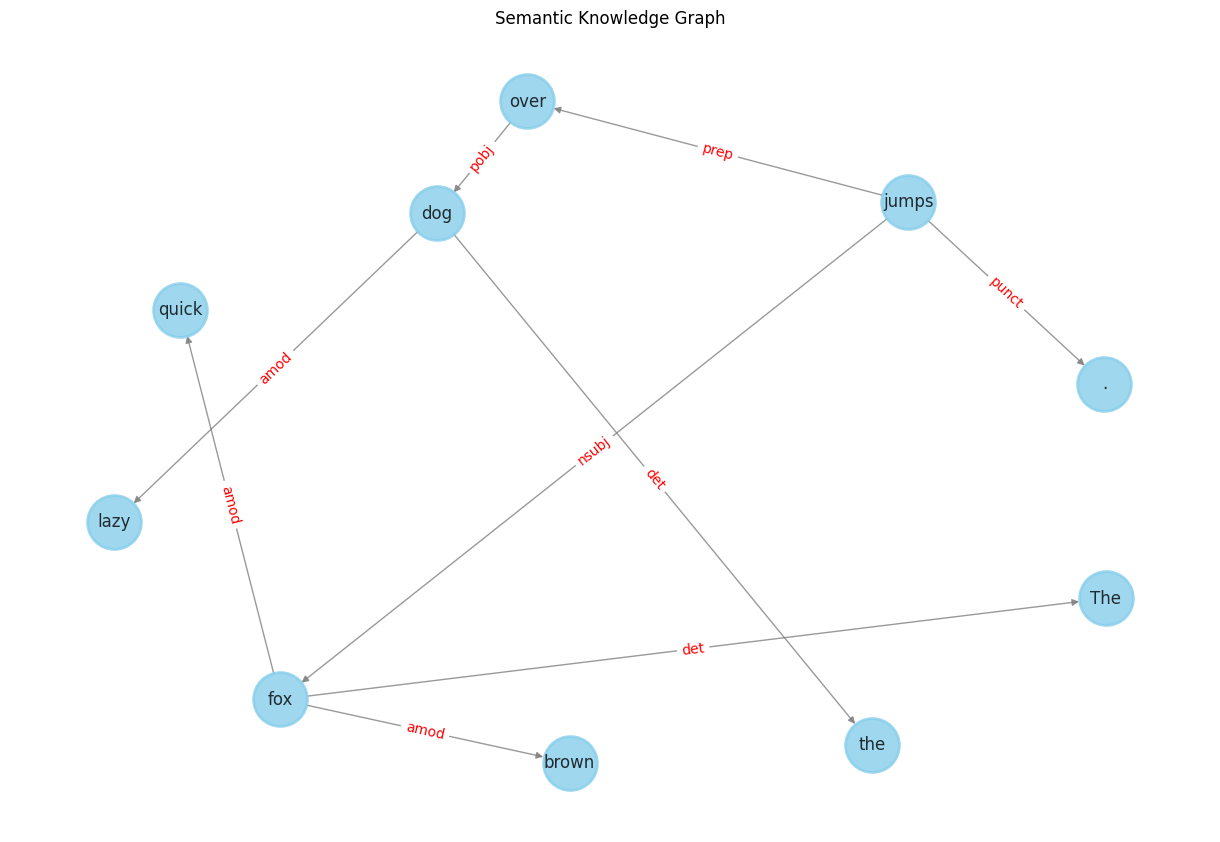

In [9]:
plot_kg(G)

## List nodes, edges

In [10]:
nodes, edges = kg_to_json(G)
print("Nodes")
print(nodes)
print()
print("Edges")
print(edges)

Nodes
[
  [
    0,
    {
      "text": "The",
      "pos": "DET",
      "head": 3,
      "lemma": "the",
      "case": "title",
      "type": "word",
      "Definite": [
        "Def"
      ],
      "PronType": [
        "Art"
      ]
    }
  ],
  [
    1,
    {
      "text": "quick",
      "pos": "ADJ",
      "head": 3,
      "lemma": "quick",
      "case": "lower",
      "type": "word",
      "Degree": [
        "Pos"
      ]
    }
  ],
  [
    2,
    {
      "text": "brown",
      "pos": "ADJ",
      "head": 3,
      "lemma": "brown",
      "case": "lower",
      "type": "word",
      "Degree": [
        "Pos"
      ]
    }
  ],
  [
    3,
    {
      "text": "fox",
      "pos": "PROPN",
      "head": 4,
      "lemma": "fox",
      "case": "lower",
      "type": "word",
      "Number": [
        "Sing"
      ]
    }
  ],
  [
    4,
    {
      "text": "jumps",
      "pos": "VERB",
      "head": 4,
      "lemma": "jump",
      "case": "lower",
      "type": "word",
      "Number": [


# Get implied relations from phrase/clause-level structures

In [11]:
result = match_chain(G, [{"pos": "VERB"}, {"type": "nsubj"}, {"pos": "PROPN"}])
print(f"\nMatches found: {result}")


Matches found: [[4, 3]]
